In [1]:
!pip install torch torchvision torchaudio

In [1]:
import torchaudio
import torch
import json
import os
# import librosa
from scipy.io import wavfile
import random
import sklearn
random.seed(10)

In [3]:
mapping_vocab = {}

with open('phone_map','r') as file:
    for i in file:
        splits=i.split(':')
        mapping_vocab[splits[0].strip()]=splits[1].strip()
        
mapping_vocab['']='_'

In [4]:
mapping_vocab

{'sil': 'sil',
 'aa': 'aa',
 'ae': 'ae',
 'ah': 'ah',
 'ao': 'aa',
 'aw': 'aw',
 'ax': 'ah',
 'ax-h': 'ah',
 'axr': 'er',
 'ay': 'ay',
 'b': 'b',
 'bcl': 'sil',
 'ch': 'ch',
 'd': 'd',
 'dcl': 'sil',
 'dh': 'dh',
 'dx': 'dx',
 'eh': 'eh',
 'el': 'l',
 'em': 'm',
 'en': 'n',
 'eng': 'ng',
 'epi': 'sil',
 'er': 'er',
 'ey': 'ey',
 'f': 'f',
 'g': 'g',
 'gcl': 'sil',
 'h#': 'sil',
 'hh': 'hh',
 'hv': 'hh',
 'ih': 'ih',
 'ix': 'ih',
 'iy': 'iy',
 'jh': 'jh',
 'k': 'k',
 'kcl': 'sil',
 'l': 'l',
 'm': 'm',
 'ng': 'ng',
 'n': 'n',
 'nx': 'n',
 'ow': 'ow',
 'oy': 'oy',
 'p': 'p',
 'pau': 'sil',
 'pcl': 'sil',
 'q': '',
 'r': 'r',
 's': 's',
 'sh': 'sh',
 't': 't',
 'tcl': 'sil',
 'th': 'th',
 'uh': 'uh',
 'uw': 'uw',
 'ux': 'uw',
 'v': 'v',
 'w': 'w',
 'y': 'y',
 'z': 'z',
 'zh': 'sh',
 '': '_'}

In [2]:
DATA_PREFIX = 'D:/SR_dataset/'

with open('train.json') as f:

    train_json = json.load(f)

for i in train_json: 
    print(i,train_json[i])
# for i in train_json:
#     splits = train_json[i]['wav'].split('/')
# #     print(splits)
#     split_index = splits.index('data')
#     splits = splits[split_index:]
#     new_file = DATA_PREFIX + '/'.join(splits)
#     train_json[i]['wav'] = new_file
#     print(train_json[i]['wav'])

FVFB0_SX312.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR1/FVFB0/SX312.WAV', 'duration': 3.79525, 'spk_id': 'FVFB0', 'phn': 'sil dh ah z ae n sil s er z l sil b ih s sil t r ey f aa r w er sil d ih f y uw sil th ih ng sil dh ah m sil th r uw sil k eh r f ah l ih f er s sil t sil', 'wrd': 'those answers will be straightforward if you think them through carefully first', 'ground_truth_phn_ends': '2190 2650 3980 5260 7200 7760 8037 9420 10700 12160 13240 13840 14080 14840 16724 16968 17455 17838 18962 21730 23268 24271 25483 26840 27300 27450 28120 29585 29905 30363 31434 32009 33040 33600 34600 34990 35277 36551 37173 38410 38793 39560 40310 41410 42451 43568 45240 45751 46638 47640 49650 52409 54723 55210 56121 60640'}
FVFB0_SX222.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR1/FVFB0/SX222.WAV.wav', 'duration': 2.5344375, 'spk_id': 'FVFB0', 'phn': 'sil y aa w ih z sil k ih m ah sil w ah th sil p ae th sil l aa sil jh ih sil k l ih sil g z ae m 

FCLT0_SX178.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR8/FCLT0/SX178.WAV', 'duration': 3.28325, 'spk_id': 'FCLT0', 'phn': 'sil sh iy ih ng sil k er ih jh sil d hh er sil ch ih l sil ah n sil t ah m ey sil dh er ow n hh ae l ah w ih ng sil k aa s sil t uw m z sil', 'wrd': 'she encouraged her children to make their own halloween costumes', 'ground_truth_phn_ends': '2220 4320 6224 7520 8320 8690 9630 11404 12580 13920 14210 14698 15110 15960 16500 17690 18680 19160 19900 20602 21480 21900 22591 23104 23920 25280 26550 26770 28281 30520 31080 32508 33800 34506 35174 36511 37200 38080 38470 39428 41720 43442 44000 44470 45640 47910 50450 52480'}
FCLT0_SX88.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR8/FCLT0/SX88.WAV', 'duration': 3.417625, 'spk_id': 'FCLT0', 'phn': 'sil f l ay ih ng s sil t ae m sil b ay sil k ae n sil b iy sil p r ae sil t ih sil k ah l ah f y uw w ah n ah s ey v sil m ah n ih sil', 'wrd': 'flying standby can be practical if y

MJEB0_SX296.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR2/MJEB0/SX296.WAV', 'duration': 2.61125, 'spk_id': 'MJEB0', 'phn': 'sil dh ih sil t uw aa r dx ih s ih sil k s sil ch ey n jh sil d aa dx ih sil r ae f s sil', 'wrd': 'the two artists exchanged autographs', 'ground_truth_phn_ends': '2370 2970 3880 4960 6050 7853 9900 10736 11400 12420 16200 18520 18928 19300 20720 21170 21810 24320 24757 26180 26680 26986 30280 30600 31357 32000 33378 35880 36971 38730 41760'}
MJEB0_SX206.WAV {'wav': '/rds/project/rds-xyBFuSj0hm0/MLMI2.M2022/data/TRAIN/DR2/MJEB0/SX206.WAV.wav', 'duration': 3.36, 'spk_id': 'MJEB0', 'phn': 'sil w ih n sil p iy l ih ng ih n aa r ih n sil jh ih dx ih z hh aa r sil n aa sil t ah s sil p r ey sil jh uw s sil', 'wrd': 'when peeling an orange it is hard not to spray juice', 'ground_truth_phn_ends': '2160 2586 3440 4488 5290 6090 7018 8396 8981 9650 10920 11480 13618 14788 15456 15998 16450 17210 18005 18730 19560 21040 21960 23533 24600 25360 26200 

In [6]:
str(torchaudio.get_audio_backend())

'soundfile'

In [7]:
# train_fbank_json={}

# import wave

# for i in train_json:
#     train_fbank_json[i]={}
#     location = train_json[i]['wav']
#     train_fbank_json[i]['spk_id']=train_json[i]['spk_id']
#     train_fbank_json[i]['duration']=train_json[i]['duration']
    
#     phns = train_json[i]['phn']
    
# #     print(phns)
# #     t=input()
#     phns = phns.split()
    
#     for j in range(len(phns)):
#         phns[j] = mapping_vocab[phns[j]]
#     phns = ' '.join(phns)
# #     print(phns)
# #     t=input()
#     train_fbank_json[i]['phn']=phns
#     splits = location.split('/')
#     split_index = splits.index('TRAIN')
#     splits2 = splits[split_index+1:-1]
#     new_location = DATA_PREFIX + 'data/fbank/train/' + '/'.join(splits2)
#     os.makedirs(new_location,exist_ok=True)
# #     print(location)
# #     t=input()
#     waveform,sample_rate = torchaudio.load(location)
# #     t=input()
#     fbank = torchaudio.compliance.kaldi.fbank(waveform,sample_rate)
# #     print(fbank.shape)
# #     print(new_location+'/'+splits[-1]+'.pt')
# #     t=input()
#     pt_loc = new_location+'/'+splits[-1]+'.pt'
#     train_fbank_json[i]['fbank'] = pt_loc
#     torch.save(fbank,pt_loc)

    
# with open('train_fbank.json', 'w') as outfile:
#     json.dump(train_fbank_json, outfile)    
    

    

In [8]:
# DATA_PREFIX = 'D:/SR_dataset/'

# with open('dev.json') as f:

#     dev_json = json.load(f)

# # for i in train_json: 
#     # print(i,train_json[i])
# for i in dev_json:
#     splits = dev_json[i]['wav'].split('/')
# #     print(splits)
#     split_index = splits.index('data')
#     splits = splits[split_index:]
#     new_file = DATA_PREFIX + '/'.join(splits)
#     dev_json[i]['wav'] = new_file
#     print(dev_json[i]['wav'])

In [9]:
# dev_json

In [10]:
# dev_fbank_json={}

# import wave

# for i in dev_json:
#     dev_fbank_json[i]={}
#     location = dev_json[i]['wav']
#     dev_fbank_json[i]['spk_id']=dev_json[i]['spk_id']
#     dev_fbank_json[i]['duration']=dev_json[i]['duration']

#     phns = dev_json[i]['phn']
    
# #     print(phns)
# #     t=input()
#     phns = phns.split()
    
#     for j in range(len(phns)):
#         phns[j] = mapping_vocab[phns[j]]
#     phns = ' '.join(phns)
# #     print(phns)
# #     t=input()
#     dev_fbank_json[i]['phn']=phns
    
#     splits = location.split('/')
#     split_index = splits.index('TEST')
#     splits2 = splits[split_index+1:-1]
#     new_location = DATA_PREFIX + 'data/fbank/dev/' + '/'.join(splits2)
#     os.makedirs(new_location,exist_ok=True)
# #     print(location)
# #     t=input()
#     waveform,sample_rate = torchaudio.load(location)
# #     t=input()
#     fbank = torchaudio.compliance.kaldi.fbank(waveform,sample_rate)
# #     print(new_location+'/'+splits[-1]+'.pt')
# #     t=input()
#     pt_loc = new_location+'/'+splits[-1]+'.pt'
#     dev_fbank_json[i]['fbank'] = pt_loc
#     torch.save(fbank,pt_loc)

    
# with open('dev_fbank.json', 'w') as outfile:
#     json.dump(dev_fbank_json, outfile)    
    

    

In [11]:

# DATA_PREFIX = 'D:/SR_dataset/'

# with open('test.json') as f:

#     test_json = json.load(f)

# # for i in train_json: 
#     # print(i,train_json[i])
# for i in test_json:
#     splits = test_json[i]['wav'].split('/')
# #     print(splits)
#     split_index = splits.index('data')
#     splits = splits[split_index:]
#     new_file = DATA_PREFIX + '/'.join(splits)
#     test_json[i]['wav'] = new_file
#     print(test_json[i]['wav'])



# test_fbank_json={}

# import wave

# for i in test_json:
#     test_fbank_json[i]={}
#     location = test_json[i]['wav']
#     test_fbank_json[i]['spk_id']=test_json[i]['spk_id']
#     test_fbank_json[i]['duration']=test_json[i]['duration']
#     phns = test_json[i]['phn']
    
# #     print(phns)
# #     t=input()
#     phns = phns.split()
    
#     for j in range(len(phns)):
#         phns[j] = mapping_vocab[phns[j]]
#     phns = ' '.join(phns)
# #     print(phns)
# #     t=input()
#     test_fbank_json[i]['phn']=phns
#     splits = location.split('/')
#     split_index = splits.index('TEST')
#     splits2 = splits[split_index+1:-1]
#     new_location = DATA_PREFIX + 'data/fbank/test/' + '/'.join(splits2)
#     os.makedirs(new_location,exist_ok=True)
# #     print(location)
# #     t=input()
#     waveform,sample_rate = torchaudio.load(location)
# #     t=input()
#     fbank = torchaudio.compliance.kaldi.fbank(waveform,sample_rate)
# #     print(fbank.shape)
# #     print(new_location+'/'+splits[-1]+'.pt')
# #     t=input()
#     pt_loc = new_location+'/'+splits[-1]+'.pt'
#     test_fbank_json[i]['fbank'] = pt_loc
#     torch.save(fbank,pt_loc)
    

# with open('test_fbank.json', 'w') as outfile:
#     json.dump(test_fbank_json, outfile)    
    


    

In [12]:

with open('train_fbank.json') as file:
    t_json = json.load(file)
    
t_json

{'FVFB0_SX312.WAV': {'spk_id': 'FVFB0',
  'duration': 3.79525,
  'phn': 'sil dh ah z ae n sil s er z l sil b ih s sil t r ey f aa r w er sil d ih f y uw sil th ih ng sil dh ah m sil th r uw sil k eh r f ah l ih f er s sil t sil',
  'fbank': 'D:/SR_dataset/data/fbank/train/DR1/FVFB0/SX312.WAV.pt'},
 'FVFB0_SX222.WAV': {'spk_id': 'FVFB0',
  'duration': 2.5344375,
  'phn': 'sil y aa w ih z sil k ih m ah sil w ah th sil p ae th sil l aa sil jh ih sil k l ih sil g z ae m sil p l sil s sil',
  'fbank': 'D:/SR_dataset/data/fbank/train/DR1/FVFB0/SX222.WAV.wav.pt'},
 'FVFB0_SX42.WAV': {'spk_id': 'FVFB0',
  'duration': 1.913625,
  'phn': 'sil b ih v l sil k l s sil k aa l er z aa r sil y uw hh ih s sh er iy sil',
  'fbank': 'D:/SR_dataset/data/fbank/train/DR1/FVFB0/SX42.WAV.pt'},
 'FVFB0_SI1032.WAV': {'spk_id': 'FVFB0',
  'duration': 2.8224375,
  'phn': 'sil ih w ih z ih s sil t aa r iy ah dh ah r ay n aa s r ih s f ay dx aa l ow v er ih sil g ae n sil',
  'fbank': 'D:/SR_dataset/data/fbank/trai

In [13]:

with open('test_fbank.json') as file:
    t_json = json.load(file)
    
t_json

{'MDAB0_SI1039.WAV': {'spk_id': 'MDAB0',
  'duration': 3.9424375,
  'phn': 'sil hh iy hh eh z n eh v er hh ih m s eh l f sil d ah n ey hh ih ng f ow w ih sil ch sil t ah sil b iy hh ey dx ih sil w ih sil ch ih v ah s hh ae z sil',
  'fbank': 'D:/SR_dataset/data/fbank/test/DR1/MDAB0/SI1039.WAV.pt'},
 'MDAB0_SI1669.WAV': {'spk_id': 'MDAB0',
  'duration': 2.0608125,
  'phn': 'sil b iy ih sil k s ay dx ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh l f sil',
  'fbank': 'D:/SR_dataset/data/fbank/test/DR1/MDAB0/SI1669.WAV.pt'},
 'MDAB0_SX49.WAV': {'spk_id': 'MDAB0',
  'duration': 2.201625,
  'phn': 'sil ae sil t sil w aa l ay sil t ah m ah sil t sil w eh l th sil d ey w l hh ae v sh ah sil b l iy sil',
  'fbank': 'D:/SR_dataset/data/fbank/test/DR1/MDAB0/SX49.WAV.wav.pt'},
 'MDAB0_SI2299.WAV': {'spk_id': 'MDAB0',
  'duration': 2.5984375,
  'phn': 'sil s ah m sil t ay m s iy sil k ow ah n s ay dx ah w ah th m ay f aa dh ih z sil b iy ng eh sil t hh ow m sil',
  'fbank': 'D:/SR_dataset/

In [14]:

with open('dev_fbank.json') as file:
    t_json = json.load(file)
    
t_json

{'MJSW0_SI1640.WAV': {'spk_id': 'MJSW0',
  'duration': 1.632,
  'phn': 'sil hh aw sil d ih sil w ah n sil jh oy n dh eh m sil',
  'fbank': 'D:/SR_dataset/data/fbank/dev/DR1/MJSW0/SI1640.WAV.pt'},
 'MJSW0_SX290.WAV': {'spk_id': 'MJSW0',
  'duration': 3.609625,
  'phn': 'sil dh ih s sil b r ow sh er ih z sil p er sil t ih sil k ih l iy ih n f aa r m ih sil t ih v f er sil p er s sil p eh sil t ih v sil b ay er sil',
  'fbank': 'D:/SR_dataset/data/fbank/dev/DR1/MJSW0/SX290.WAV.pt'},
 'MJSW0_SX20.WAV': {'spk_id': 'MJSW0',
  'duration': 3.53925,
  'phn': 'sil sh iy w aa r w aa r m f l iy s iy w uh l eh n ow v er aa l z sil',
  'fbank': 'D:/SR_dataset/data/fbank/dev/DR1/MJSW0/SX20.WAV.pt'},
 'MJSW0_SX200.WAV': {'spk_id': 'MJSW0',
  'duration': 2.5344375,
  'phn': 'sil r ae l f sil k ih n sil t r ow l dh ah s sil t aa sil w aa sil ch f r ah m ah sil b l iy sil ch er s sil',
  'fbank': 'D:/SR_dataset/data/fbank/dev/DR1/MJSW0/SX200.WAV.pt'},
 'MJSW0_SX380.WAV': {'spk_id': 'MJSW0',
  'duration':

# Features

## Use `dataloader` to get an utterance

In [15]:
from dataloader import get_dataloader
import torch
import numpy as np

In [16]:
loader = get_dataloader('train_fbank.json', 1, False)
data_iter = iter(loader)

In [17]:
fbank, lens, trans, dur = next(data_iter)

In [18]:
print('The utterance has {} seconds.'.format(dur[0]))
print('Filter bank feature has {} frames and {} dimensions.'.format(
    fbank.shape[0], fbank.shape[2]))
print('The correspoinding transcription is: {}.'.format(trans[0]))

The utterance has 3.79525 seconds.
Filter bank feature has 378 frames and 23 dimensions.
The correspoinding transcription is: sil dh ah z ae n sil s er z l sil b ih s sil t r ey f aa r w er sil d ih f y uw sil th ih ng sil dh ah m sil th r uw sil k eh r f ah l ih f er s sil t sil.


## Plot FBANK

<Figure size 432x288 with 0 Axes>

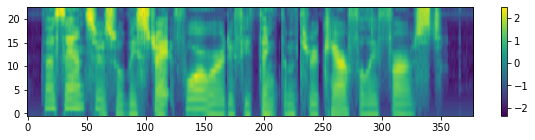

In [19]:
import matplotlib.pyplot as plt
import numpy as np

feature = np.transpose(fbank[:, 0, :].numpy())
plt.clf()
plt.figure(figsize=(10,2))
plt.imshow(feature, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

# CTC model for ASR

## Obtain phoneme output units

In [20]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

In [21]:
# # Count the number of times each phone appear in the training set
# # and save the numbers correcponding to each phone in vocab.txt 
# # into counts.txt

# counts = []
# with open("counts.txt") as f:
#     for i in f:
#         counts.append(int(i))

## Plot frequencies of graphemes

In [22]:
# plt.clf()
# plt.figure(figsize=(10,2))
# freq = np.array(counts) / np.sum(counts) * 100
# plt.bar(phonemes, freq)
# plt.show()

## Model & training configurations

In [23]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 1,
        'fbank_dims': 23,
        'model_dims': 128,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'num_epochs': 25,
        'device': device,
       }

args = namedtuple('x', args)(**args)

In [24]:
import models
model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab))
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 166952


## Training

In [25]:
from datetime import datetime
from trainer import train
start = datetime.now()
model.to(args.device)
model_path,history = train(model, args)
end = datetime.now()
duration = (end - start).total_seconds()
print('Training finished in {} minutes.'.format(divmod(duration, 60)[0]))
print('Model saved to {}'.format(model_path))

EPOCH 1:
  batch 50 loss: 4.186413111686707
  batch 100 loss: 3.2525889444351197
  batch 150 loss: 3.0696567916870117
  batch 200 loss: 2.816366820335388
  batch 250 loss: 2.605407304763794
  batch 300 loss: 2.4314752578735352
  batch 350 loss: 2.310380392074585
  batch 400 loss: 2.2755553770065307
  batch 450 loss: 2.196756114959717
  batch 500 loss: 2.0971583318710327
  batch 550 loss: 2.0530559968948365
  batch 600 loss: 2.003693096637726
  batch 650 loss: 1.9521764731407165
  batch 700 loss: 1.9053557896614075
  batch 750 loss: 1.8442505478858948
  batch 800 loss: 1.8241379618644715
  batch 850 loss: 1.771151044368744
  batch 900 loss: 1.7498273468017578
LOSS train 1.74983 valid 1.70435, valid PER 63.80%
EPOCH 2:
  batch 50 loss: 1.7168947672843933
  batch 100 loss: 1.6323612308502198
  batch 150 loss: 1.6438595008850099
  batch 200 loss: 1.634853196144104
  batch 250 loss: 1.6430164289474487
  batch 300 loss: 1.599227910041809
  batch 350 loss: 1.5164196729660033
  batch 400 loss:

  batch 400 loss: 0.8382608532905579
  batch 450 loss: 0.8437975096702576
  batch 500 loss: 0.8459967160224915
  batch 550 loss: 0.7797702807188034
  batch 600 loss: 0.8206132876873017
  batch 650 loss: 0.851779602766037
  batch 700 loss: 0.8426936054229737
  batch 750 loss: 0.8601690566539765
  batch 800 loss: 0.8294255149364471
  batch 850 loss: 0.8590474009513855
  batch 900 loss: 0.8563466000556946
LOSS train 0.85635 valid 0.97235, valid PER 30.06%
EPOCH 13:
  batch 50 loss: 0.7611294722557068
  batch 100 loss: 0.7912624073028565
  batch 150 loss: 0.7429408383369446
  batch 200 loss: 0.7899261701107025
  batch 250 loss: 0.7873801124095917
  batch 300 loss: 0.7751602375507355
  batch 350 loss: 0.785496072769165
  batch 400 loss: 0.8323957240581512
  batch 450 loss: 0.8019749128818512
  batch 500 loss: 0.7755542093515396
  batch 550 loss: 0.8122056674957275
  batch 600 loss: 0.8295345520973205
  batch 650 loss: 0.8335173273086548
  batch 700 loss: 0.8404862129688263
  batch 750 loss:

  batch 750 loss: 0.7267560797929764
  batch 800 loss: 0.7154670864343643
  batch 850 loss: 0.6840784400701523
  batch 900 loss: 0.6764832758903503
LOSS train 0.67648 valid 1.02256, valid PER 30.08%
EPOCH 24:
  batch 50 loss: 0.6332618176937104
  batch 100 loss: 0.6080280733108521
  batch 150 loss: 0.6369529247283936
  batch 200 loss: 0.6518048071861267
  batch 250 loss: 0.6686662131547928
  batch 300 loss: 0.6785304087400437
  batch 350 loss: 0.6352399843931198
  batch 400 loss: 0.6769046223163605
  batch 450 loss: 0.6989233404397964
  batch 500 loss: 0.7237900412082672
  batch 550 loss: 0.73591856777668
  batch 600 loss: 0.7345104658603668
  batch 650 loss: 0.7838032960891723
  batch 700 loss: 0.7567926967144012
  batch 750 loss: 0.7266800040006638
  batch 800 loss: 0.705541867017746
  batch 850 loss: 0.732294420003891
  batch 900 loss: 0.7372457528114319
LOSS train 0.73725 valid 1.06349, valid PER 31.24%
EPOCH 25:
  batch 50 loss: 0.6554100716114044
  batch 100 loss: 0.6780286288261

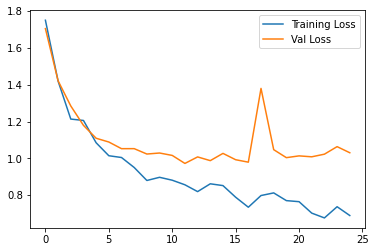

In [26]:
import matplotlib.pyplot as plt
temp = [1]*len(history['loss'])
plt.plot(history['loss'],label='Training Loss')
plt.plot(history['val_loss'],label='Val Loss')
plt.plot(temp,'--')
plt.legend()
plt.show()

## Decoding

In [27]:
### You can uncomment the following line and change model path to the model you want to decode
# model_path="checkpoints/20221110_120418/model_16"

In [28]:
import torch
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Loading model from checkpoints/20230121_191836/model_12


BiLSTM(
  (lstm): LSTM(23, 128, bidirectional=True)
  (proj): Linear(in_features=256, out_features=40, bias=True)
)

In [29]:
from decoder import decode
results = decode(model, args, args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

SUB: 16.95%, DEL: 12.40%, INS: 2.29%, COR: 70.65%, PER: 31.64%
